In [2]:
%matplotlib inline

import numpy as np
import mplcyberpunk
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.style.use("cyberpunk")

rcParams["font.sans-serif"] = "Roboto"
rcParams["xtick.labelsize"] = 14.
rcParams["ytick.labelsize"] = 14.
rcParams["axes.labelsize"] = 14.
rcParams["legend.fontsize"] = 14
rcParams["axes.titlesize"] = 16.

In [3]:
np.random.seed(42)

_ = torch.manual_seed(42)

# Auxiliary Functions

This notebook is a compilation of a few aspects that are "secondary" to deep learning models. This provides a quick overview using PyTorch.

## Exponential Activation Functions

These activation functions all contain exponential functions, and so vary relatively smoothly with $x$. The general purpose of these functions is to compress output values such that they lie within a certain range, and eventually asymptote/saturate at some point. The sigmoid and tanh functions in particular are classic activation functions, but as you will see below, their derivatives go to zero quite quickly with larger values of $x$.

### Sigmoid

$$ \sigma(x) = \frac{1}{1 + \exp(-x)} $$

Collapses values to the range of [0,1]; used traditionally to mimic neurons firing, although saturates very easily with values of $x$ not near zero and so is less commonly used now between layers, but more for binary classification (0 or 1) or [Bernoulli trial.](https://en.wikipedia.org/wiki/Bernoulli_distribution)

### Softmax

$$ \mathrm{softmax}(x) = \frac{\exp(x)}{\sum \exp(x)} $$

Forces the vector to sum to 1 like probabilities of multiple independent events. Used commonly for multiclass classification, which outputs the likelihood of a given class.

### Softplus

$$ \mathrm{softplus}(x) = \frac{1}{\beta}\log(1 + \exp(\beta x))$$

### tanh

$$ \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)} $$

In [4]:
x = torch.arange(-2, 2, step=0.1)
x.requires_grad_(True)
y = x**2.

In [5]:
y.backward(x)

/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  
/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.


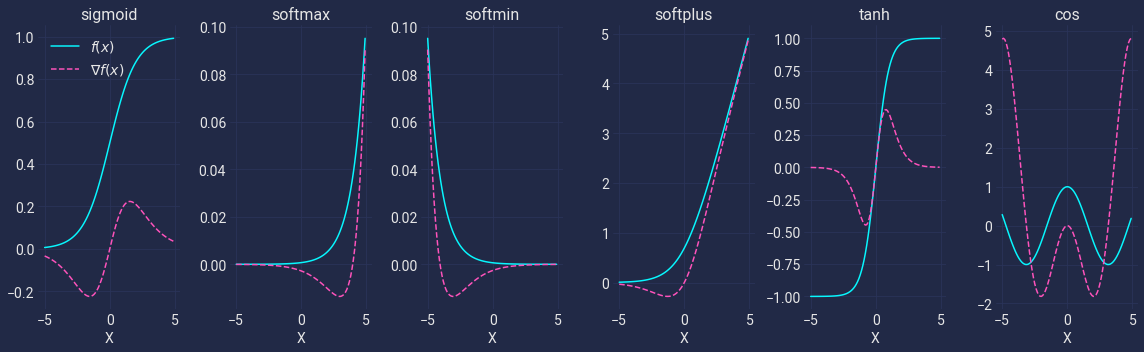

In [6]:
funcs = [torch.sigmoid,  F.softmax, F.softmin, F.softplus, torch.tanh, torch.cos]

fig, axarray = plt.subplots(1, len(funcs), figsize=(16,5.))

with torch.no_grad():
    for ax, func in zip(axarray, funcs):
        X = torch.arange(-5, 5., step=0.1)
        Y = func(X)
        ax.plot(X, Y, lw=1.5,  alpha=1., label="$f(x)$")
        ax.set_title(func.__name__)
        ax.set_xlabel("X")

# Compute gradients this time
for ax, func in zip(axarray, funcs):
    X = torch.arange(-5, 5., step=0.1)
    X.requires_grad_(True)
    Y = func(X)
    Y.backward(X)
    grads = X.grad
    ax.plot(X.detach(), grads.numpy(), lw=1.5,  alpha=1., label="$\\nabla f(x)$", ls="--")

axarray[0].legend(loc=2)
fig.tight_layout()

## Activation Functions

### Rectified Linear Unit (ReLU)

$$ \mathrm{ReLU}(x) = \mathrm{max(0, x)} $$

Despite having little statistical interpretation (compared to sigmoid, for example), it works well for most tasks.

### Exponential Linear Unit (ELU)

$$ \mathrm{ELU}(x) = \mathrm{max}(0,x) + \mathrm{min}(0, \alpha \exp(x) - 1) $$

where $\alpha$ is a hyperparameter tuned to change the rate of change. Allows the gradient to be non-zero with small values of $x$, and only asymptotes at very negative values.

### Leaky ReLU

$$ \mathrm{LeakyReLU}(x) = \mathrm{max}(0,x) + \alpha \mathrm{min}(0,x) $$

where $\alpha$ is a hyperparameter tuned to allow some negative gradients backpropagate; otherwise they would asymptote to zero as in ReLU.

### ReLU6

$$ \mathrm{ReLU6}(x) = \mathrm{min}(\mathrm{max(0, x)}, 6) $$

### Scaled Exponential Linear Unit (SELU)

$$ \mathrm{SELU}(x) = \lambda \mathrm{max}(0, x) + \mathrm{min}(0,\alpha (\exp(x) - 1)) $$

where $\lambda$ and $\alpha$ are hyperparameters, although were numerically tuned to $\alpha=1.6733$ and $\lambda=1.0507$
for [self-normalizing neural networks](https://arxiv.org/pdf/1706.02515.pdf).

### Gaussian Error Linear Unit (GELU)

$$ \mathrm{GELU}(x) = x \Phi(x) $$

where $\Phi(x)$ is the cumulative distribution function for a standard Gaussian distribution. Allows for [self-regularization to a certain extent](https://arxiv.org/pdf/1606.08415.pdf) similar to dropouts.

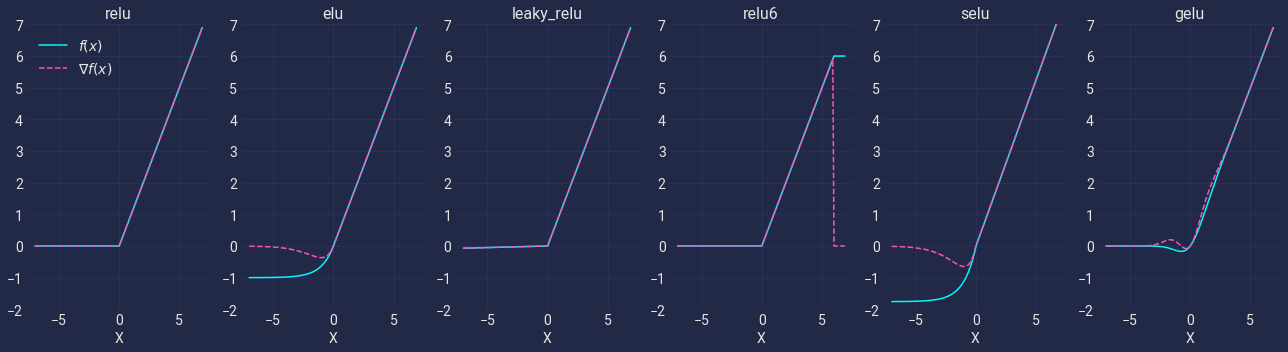

In [9]:
funcs = [F.relu,  F.elu, F.leaky_relu, F.relu6, torch.selu, F.gelu]

fig, axarray = plt.subplots(1, len(funcs), figsize=(18,5.))

with torch.no_grad():
    for ax, func in zip(axarray, funcs):
        X = torch.arange(-7, 7., step=0.1)
        Y = func(X)
        ax.plot(X, Y, lw=1.5,  alpha=1., label="$f(x)$")
        ax.set_title(func.__name__)
        ax.set_xlabel("X")

for ax, func in zip(axarray, funcs):
    X = torch.autograd.Variable(torch.arange(-7, 7., step=0.1), requires_grad=True)
    Y = func(X)
    torch.autograd.backward([Y], [X])
    grads = X.grad
    ax.plot(X.detach(), grads.numpy(), lw=1.5,  alpha=1., label="$\\nabla f(x)$", ls="--")
    ax.set_ylim([-2., 7.])

axarray[0].legend(loc=2)
fig.tight_layout()

## Loss functions

Designing an appropriate loss function is probably the most important aspect of deep learning: you can be creative about how to encourage your model to learn about the problem. You can find all the loss functions implemented in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions), and mix and match them to make your model learn what you want it to learn.

### Mean squared error

Probably the most commonly used loss in machine learning: individual predictions scale quadratically away from the ground truth, but the actual objective of this function is to learn to reproduce the _mean_ of your data.

$$ \mathcal{L} = \frac{1}{N}\sqrt{\sum^I_i(\hat{y}_i - y_i)^2} $$

Something worth noting here, is that minimizing the mean squared error is equivalent to maximizing the $\log$ likelihood in _most_ circumstances assuming normally distributed errors. In other words, predictions with models trained on the MSE loss can be thought of as the maximum likelihood estimate. [Read here](https://www.jessicayung.com/mse-as-maximum-likelihood/) for more details.

### Kullback-Leibler divergence

Less commonly encountered in the physical sciences unless you work with some information theory. This is an asymmetric loss function, contrasting the mean squared error, and is useful for estimating ``distances'' between probability distributions. Effectively, this loss function measures the extra amount of information you need for a distribution $q$ to encode another distribution $p$; when the two distributions are exactly equivalent, then $D_\mathrm{KL}$ is zero.

$$ D_\mathrm{KL}(p \vert \vert q) = p \frac{\log p}{\log q} $$

This loss is asymmetric, because $D_\mathrm{KL}(p \vert \vert q) \neq D_\mathrm{KL}(q \vert \vert p)$. To illustrate, we plot two Gaussians below:

In [12]:
from scipy.stats import entropy, norm

In [33]:
x = np.linspace(-5., 5., 1000)
p = norm(loc=-1.5, scale=0.7).pdf(x)
q = norm(loc=2., scale=0.3).pdf(x) + norm(loc=-2.5, scale=1.3).pdf(x)

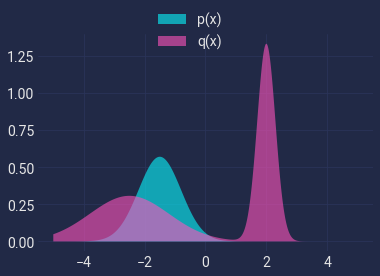

In [43]:
fig, ax = plt.subplots()

ax.fill_between(x, p, 0., label="p(x)", alpha=0.6)
ax.fill_between(x, q, 0., label="q(x)", alpha=0.6)
fig.legend(loc="upper center");

The $D_\mathrm{KL}$ for each direction:

In [35]:
dpq = entropy(p, q)
dqp = entropy(q, p)

print(f"D(p||q) = {dpq:.3f}, D(q||p) = {dqp:.3f}")

D(p||q) = 1.239, D(q||p) = 6.530


The way to interpret this is coverage: $D_\mathrm{KL}(p \vert \vert q)$ is smaller than $D_\mathrm{KL}(q \vert \vert p)$, because if you wanted to express $p$ with $q$ you would do an okay job (at least with respect to the left Gaussian). Conversely, if you wanted to use $p$ to represent $q$ ($D_\mathrm{KL}(q \vert \vert p)$) it would do a poor job of representing the right Gaussian. Another way of looking at it is at their cumulative distribution functions:

In [31]:
cdf_p = norm(loc=-0.8, scale=0.7).cdf(x)
cdf_q = norm(loc=2., scale=0.3).cdf(x) + norm(loc=-2.5, scale=1.3).cdf(x)

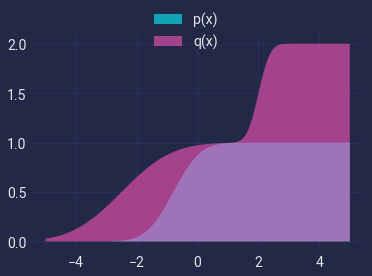

In [42]:
fig, ax = plt.subplots()

ax.fill_between(x, cdf_p, 0., label="p(x)", alpha=0.6)
ax.fill_between(x, cdf_q, 0., label="q(x)", alpha=0.6)
fig.legend(loc="upper center");

The (unnormalized) CDFs show how $p$ does not contain any knowledge at higher values of $x$, leading to a higher $D_\mathrm{KL}$.

### Binary cross entropy

This represents a special, yet common enough loss, for binomial targets $[0,1]$. This is usually used for classification tasks, but also for predicting pixel intensities (if they fall in the $[0,1]$ range).

$$ \mathcal{L} = -[y \cdot \log \hat{y} + (1 - y) \cdot \log(1 - \hat{y})] $$

### A note on implementations

You will more often than not in many deep learning libraries see a "X with logits" implementation of some X loss function. For example, the binary cross entropy in PyTorch has a `BCEWithLogits` and a `BCELoss` implementation. When possible, you use the former, as it ensures numerical stability by taking advantage of $\log$ of very small numbers. For example when multiplying by likelihoods, you can end up with rounding errors due to a loss in number precision: for $p_a = 10^{-5}$ and $p_b = 10^{-7}$, you preserve the precision by doing $p_a \times p_b$ in $\log$ space, which would be $(-5) + (-7)$ in $\log_{10}$, as opposed to $10^{-12}$.

If you use `BCEWithLogits`, the loss function will include the sigmoid activation function, and the output layer (if it learns) will generate the $\log$ likelihood as its output.